In [2]:
import os
import random
from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
import torchvision.transforms.functional as func

In [3]:
def generate_d4_augmentations(image):
    """
    Given a grayscale image tensor of shape (1, 224, 224),
    return a list of 8 image tensors with D4 augmentations:
    [original, rot90, rot180, rot270, hflip, vflip, diag1_flip, diag2_flip]
    """
    assert image.shape == (1, 224, 224), "Image must be of shape (1, 224, 224)"

    original = image
    rot90 = func.rotate(image, angle=90)
    rot180 = func.rotate(image, angle=180)
    rot270 = func.rotate(image, angle=270)
    hflip = func.hflip(image)
    vflip = func.vflip(image)

    diag1_flip = torch.transpose(image, 1, 2)
    diag2_flip = torch.flip(torch.transpose(image, 1, 2), dims=[2])

    return [original, rot90, rot180, rot270, hflip, vflip, diag1_flip, diag2_flip]


def apply_affine_transform(image_tensor,
                           max_rotation=15,
                           max_translation=0.05,
                           scale_range=(0.95, 1.05),
                           max_shear=5):
    """
    Apply a small random affine transformation to a grayscale image tensor.

    Args:
        image_tensor (torch.Tensor): Tensor of shape (1, H, W) with values in [0, 1]
        max_rotation (float): Max degrees for rotation (±)
        max_translation (float): Max proportion of width/height to translate
        scale_range (tuple): Min and max scale factors
        max_shear (float): Max shear angle in degrees (±)

    Returns:
        torch.Tensor: Transformed image tensor (1, H, W)
    """
    _, h, w = image_tensor.shape

    angle = random.uniform(-max_rotation, max_rotation)
    translate_x = int(max_translation * w * random.uniform(-1, 1))
    translate_y = int(max_translation * h * random.uniform(-1, 1))
    scale = random.uniform(*scale_range)
    shear = random.uniform(-max_shear, max_shear)
    mean = torch.mean(image_tensor)

    transformed = func.affine(
        image_tensor,
        angle=angle,
        translate=[translate_x, translate_y],
        scale=scale,
        shear=shear,
        interpolation=func.InterpolationMode.BILINEAR,
        fill=mean.item()
    )

    return transformed


def get_augmented_images(image_tensor: torch.Tensor, augmentation="low") -> list[torch.Tensor]:
    augmented_images = generate_d4_augmentations(image_tensor)

    if augmentation == "low":
        return random.sample(augmented_images, k=4)

    elif augmentation == "medium":
        return augmented_images

    transformed = [apply_affine_transform(i) for i in augmented_images]
    return augmented_images + transformed


In [4]:
class SkinCancerDataset(Dataset):
    def __init__(self, transform, path, train=True):
        self.samples = []
        self.num_samples = {i: 0 for i in range(7)}

        for file_path in glob(os.path.join(path, "*.jpg")):
            file_name = os.path.basename(file_path)
            class_id = int(file_name.split("_")[0])

            image = read_image(file_path).float()
            image = transform(image)

            if not train:
                self.samples.append((image, class_id - 1))
                self.num_samples[class_id - 1] += 1
                continue

            if class_id in [3, 5]:  # 1 image -> 4 images
                images = get_augmented_images(image, augmentation="low")
            elif class_id in [1, 2]:  # 1 image -> 8 images
                images = get_augmented_images(image, augmentation="medium")
            elif class_id in [4, 7]:  # 1 image -> 16 images
                images = get_augmented_images(image, augmentation="high")
            else:
                images = [image]

            for i in images:
                if class_id == 6 and self.num_samples[class_id - 1] < 1000:
                    self.samples.append((i, class_id - 1))
                    self.num_samples[class_id - 1] += 1
                elif class_id != 6:
                    self.samples.append((i, class_id - 1))
                    self.num_samples[class_id - 1] += 1

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        tensor, label = self.samples[idx]
        return tensor, label


In [5]:
folder_path = "train"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_set = SkinCancerDataset(transform, folder_path)

print(len(train_set))
print(train_set.num_samples)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_set = SkinCancerDataset(transform, "val", train=False)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)
print(len(val_set))

6600
{0: 896, 1: 1184, 2: 1372, 3: 576, 4: 1012, 5: 1000, 6: 560}
1000


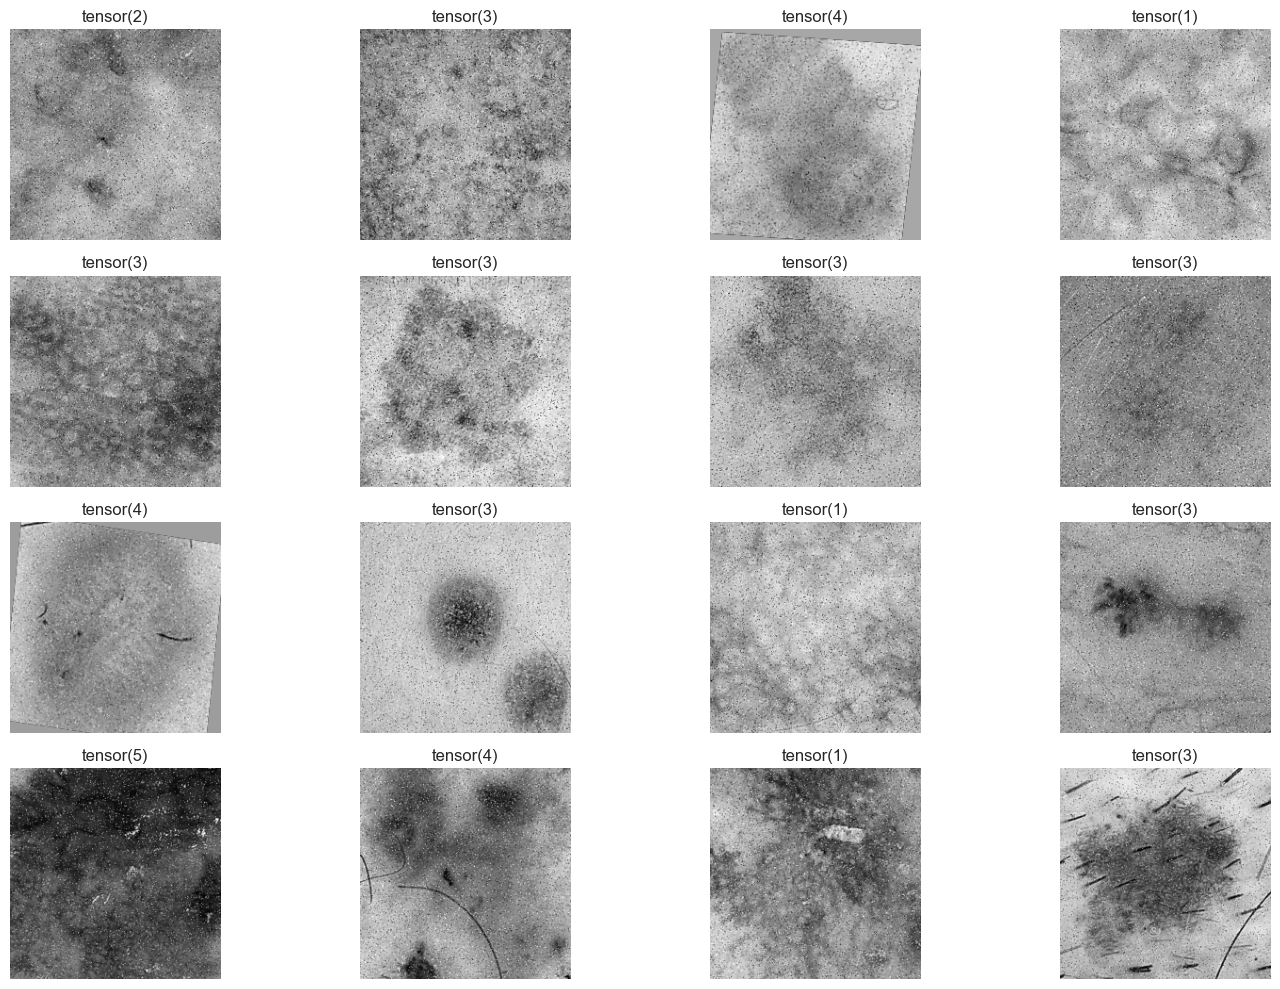

In [6]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))
images = images.view(len(images), 224, 224).detach().numpy()

rows = (len(images) + 4 - 1) // 4
plt.figure(figsize=(15, 10))
for i, img in enumerate(images):
    plt.subplot(rows, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(str(labels[i] + 1))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

class MobileNetV3Gray(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()

        self.model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)

        self.model.features[0][0] = nn.Conv2d(
            in_channels=1,
            out_channels=16,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False
        )

        in_features = self.model.classifier[3].in_features
        self.model.classifier[3] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetV3Gray(num_classes=7).to(device)
print(model)

MobileNetV3Gray(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivat

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 5

In [34]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

all_labels = [label for _, label in train_set]

classes = np.unique(all_labels)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=all_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

In [35]:
from tqdm import tqdm

losses = []
val_accuracies = []
for epoch in range(num_epochs):
    epoch_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")

    model.train()
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        running_loss = epoch_loss / len(train_loader)
        loop.set_postfix(running_loss=running_loss)

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0

        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += torch.eq(predicted, labels).sum().item()

    val_accuracies.append(correct / total)
    losses.append(epoch_loss / len(train_loader))

    scheduler.step()


Epoch 5/5: 100%|██████████| 413/413 [00:24<00:00, 16.92it/s, running_loss=0.297] 


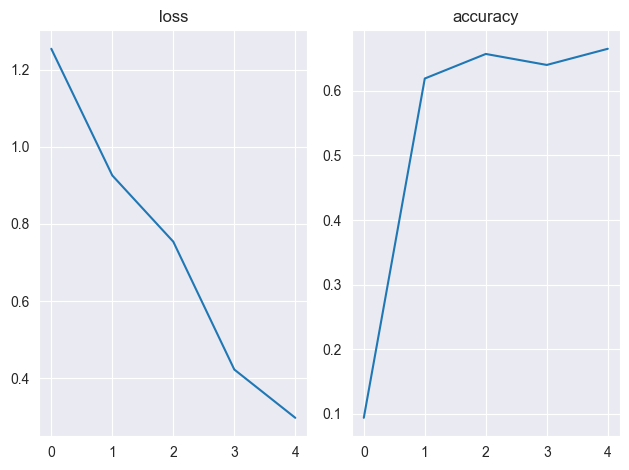

In [36]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2)

axes[0].plot(losses)
axes[0].set_title('loss')
axes[1].plot(val_accuracies)
axes[1].set_title('accuracy')

plt.tight_layout()
plt.show()

Overall accuracy: 66.50%
Per class accuracy:
Class 1: 61.11%
Class 2: 63.33%
Class 3: 51.96%
Class 4: 33.33%
Class 5: 50.52%
Class 6: 73.13%
Class 7: 40.00%


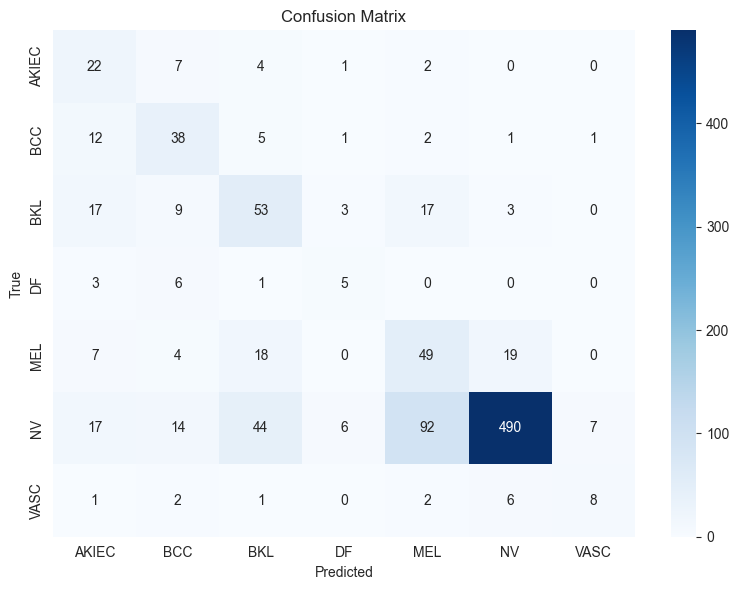

In [37]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    correct = [0] * 7
    total = [0] * 7

    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Store predictions and true labels for confusion matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for true, pred in zip(labels, predicted):
            total[true] += 1
            correct[true] += int(true == pred)

# Print accuracies
print(f"Overall accuracy: {100 * sum(correct) / sum(total):.2f}%")
print("Per class accuracy:")
for i, (c, t) in enumerate(zip(correct, total)):
    print(f"Class {i + 1}: {100 * c / t:.2f}%")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["AKIEC", "BCC", "BKL", "DF", "MEL", "NV", "VASC"],
            yticklabels=["AKIEC", "BCC", "BKL", "DF", "MEL", "NV", "VASC"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [38]:
torch.save(model.state_dict(), "model_2.pth")

# TESTING THE MODEL

In [ ]:
path = ""  # put in the path ot the test dataset here



import os
import random
from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
import torchvision.transforms.functional as func
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights


class SkinCancerDataset(Dataset):
    def __init__(self, transform, path, train=True):
        self.samples = []
        self.num_samples = {i: 0 for i in range(7)}

        for file_path in glob(os.path.join(path, "*.jpg")):
            file_name = os.path.basename(file_path)
            class_id = int(file_name.split("_")[0])

            image = read_image(file_path).float()
            image = transform(image)

            if not train:
                self.samples.append((image, class_id - 1))
                self.num_samples[class_id - 1] += 1
                continue

            if class_id in [3, 5]:  # 1 image -> 4 images
                images = get_augmented_images(image, augmentation="low")
            elif class_id in [1, 2]:  # 1 image -> 8 images
                images = get_augmented_images(image, augmentation="medium")
            elif class_id in [4, 7]:  # 1 image -> 32 images
                images = get_augmented_images(image, augmentation="high")
            else:
                images = [image]

            for i in images:
                if class_id == 6 and self.num_samples[class_id - 1] < 1000:
                    self.samples.append((i, class_id - 1))
                    self.num_samples[class_id - 1] += 1
                elif class_id != 6:
                    self.samples.append((i, class_id - 1))
                    self.num_samples[class_id - 1] += 1

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        tensor, label = self.samples[idx]
        return tensor, label


class MobileNetV3Gray(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        self.model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)

        self.model.features[0][0] = nn.Conv2d(
            in_channels=1,
            out_channels=16,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False
        )

        in_features = self.model.classifier[3].in_features
        self.model.classifier[3] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetV3Gray(num_classes=7).to(device)
model.load_state_dict(torch.load("model_2.pth", weights_only=True))

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


test_set = SkinCancerDataset(transform, path, train=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

model.eval()
with torch.no_grad():
    correct = [0] * 7
    total = [0] * 7

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

        for true, pred in zip(labels, predicted):
            total[true] += 1
            correct[true] += int(true == pred)

    print(f"Overall accuracy: {100 * sum(correct) / sum(total):.2f}")
    print("\nPer class accuracy:")
    for i, (correct, total) in enumerate(zip(correct, total)):
        print(f"Class {i + 1}: {100 * correct / total:.2f}%")
